Import statements:

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Overview

Data is queried from the neo4j database containing the LDN dataset of the Swift ecosystem: https://doi.org/10.5281/zenodo.6376008

For each csv file used in the following analysis the cypher query used to query the database is listed as well. 

Overall the database contains the following nodes: 
- Project (project inclucing repository information)
- App (an analysed project version)
- Library (library version that was referenced from a resolution file of a library)
- LibraryDependency (library version that was referenced from a manifest file of a library)
- Vulnerability (vulnerability queried from NVD)

The above nodes are connected with the following relationships
- (Project)-[:HAS APP]->(App)
- (App)-[:IS]->(Library)
- (App)-[:DEPENDS ON]->(Library)
- (App)-[:DEPENDS ON]->(LibraryDefinition)
- (Library)-[:HAS VULNERABILITY]->(Vulnerability)

This notebook how analysis for the article "Analysis of Dependency Networks of Package Managers Used in iOS Development" was carried out and makes it easy to replicate the results. The csv files used are provided with the notebook but can also be queried from the neo4j database using the queries listed. 

The following notebook is divided into four chapters: Overview, RQ1, RQ2 and RQ3. 

First we plot the cumulative number of libraries and library versions over time. 

First to retreive information on libraries added we read in a csv file with information on first occurrence of libraries. Used query: 
   
    match 
        (app:App) 
    where 
        not (:App)-[:CHANGED_TO]->(app) 
    return 
        distinct app.name as name, 
        app.tag as tag, 
        app.timestamp as timestamp

In [2]:
firsts = pd.read_csv('all-firsts.csv')

Parsing timestamp as date and calculating both month and year periods so that data can be filtered more easily.

In [3]:
firsts['date'] = firsts['timestamp'].apply(datetime.datetime.fromtimestamp)
firsts['month'] = firsts['date'].dt.to_period('M')
firsts['year'] = firsts['date'].dt.to_period('Y')

firsts = firsts[firsts['year'] != '2022']

Reading in csv file with information on all analysed library versions. No type means that package manager type is not included and there are therefore no duplicate rows due to multiple package managers. 

Used query: 

    match 
        (a:App)-[:IS]->(l:Library) 
    optional match 
        (a)-[:DEPENDS_ON]->(dependency:Library) 
    optional match 
        (dependent:App)-[:DEPENDS_ON]->(l) 
    return 
        a.name as library_name, 
        a.tag as tag, 
        a.timestamp as timestamp, 
        count(DISTINCT dependency.name) as dependency_count, 
        count(DISTINCT dependent.name) as dependent_count

In [4]:
dep_no_type = pd.read_csv('dependencies_no_type.csv')
dep_no_type.count()

library_name        574080
tag                 574079
timestamp           574080
dependency_count    574080
dependent_count     574080
dtype: int64

Parsing timestamp as date and calculating both month and year periods so that data can be filtered and plotted more easily.

In [5]:
dep_no_type['date'] = dep_no_type['timestamp'].apply(datetime.datetime.fromtimestamp)
dep_no_type['month'] = dep_no_type['date'].dt.to_period('M')
dep_no_type['year'] = dep_no_type['date'].dt.to_period('Y')

dep_no_type = dep_no_type[dep_no_type['year'] != '2022']

Plotting the cumulative number of libraries and library versions:

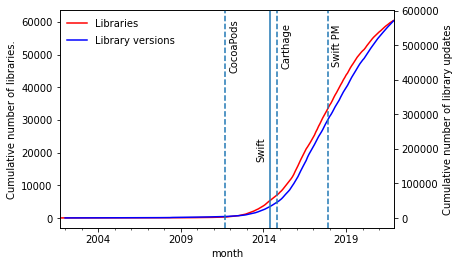

In [6]:
ax = firsts.groupby(['month']).size().cumsum().plot(color='r')

ax2 = dep_no_type[dep_no_type['year'].between('2002.01.01', '2021.12.31')].groupby(['month']).size().cumsum().plot(secondary_y=True,color='b', ax=ax)

plt.xlabel("Year")

ax.set_ylabel('Cumulative number of libraries.')
ax2.set_ylabel('Cumulative number of library updates')

ax.legend(['Libraries'], loc=(.01,.9), frameon = False)
ax2.legend(['Library versions'], loc=(.01,.82), frameon = False)

cocoa_time = pd.Period('2011-09', 'M')
plt.axvline(cocoa_time, linestyle='--')
plt.text(cocoa_time + pd.offsets.MonthEnd(3), 500000, "CocoaPods", rotation=90, verticalalignment='center')

carthage_time = pd.Period('2014-11', 'M')
plt.axvline(carthage_time, linestyle='--')
plt.text(carthage_time + pd.offsets.MonthEnd(3), 500000, "Carthage", rotation=90, verticalalignment='center')

swift_time = pd.Period('2014-06', 'M')
plt.axvline(swift_time, linestyle='-')
plt.text(swift_time - pd.offsets.MonthEnd(10), 200000, "Swift", rotation=90, verticalalignment='center')

swiftpm_time = pd.Period('2017-12', 'M')
plt.axvline(swiftpm_time, linestyle='--')
plt.text(swiftpm_time + pd.offsets.MonthEnd(3), 500000, "Swift PM", rotation=90, verticalalignment='center')
plt.tight_layout


plt.savefig('plot_number_of_libraries_cumulative_both.pdf', bbox_inches = "tight")

Plotting new libraries added each month:

Text(0, 0.5, 'Number of new libraries added.')

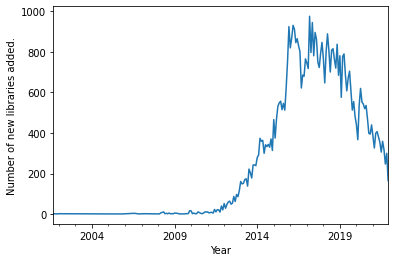

In [7]:
firsts.groupby(['month']).size().plot()

plt.xlabel("Year")
plt.ylabel("Number of new libraries added.")

Text(0, 0.5, 'Number of new library versions added.')

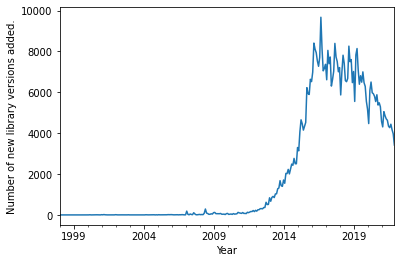

In [8]:
dep_no_type.groupby(['month']).size().plot()

plt.xlabel("Year")
plt.ylabel("Number of new library versions added.")

In the following only connected libraries are analysed, i.e. libraries that are either used through other libraries or that are using other libraries. 

# RQ1: Overlap of the CocoaPods, Carthage, and Swift PM Library Dependency Networks

RQ1 is answered by querying yearly snapshot data from the database. The numbers are reported and plotted manually using https://app.diagrams.net

We first find a yearly snapshot of library versions for the years 2016, 2018, 2020 and 2021 to see how many libraries are using a package manager: 

    match (p:Project)-[:HAS_APP]->(a:App)
    with p, a, date(datetime({epochSeconds:toInteger(a.timestamp)})) as created
    WHERE date({year: 2021, month: 1}) <= created < date({year: 2022, month: 1})
    with p, a order by created
    with p, collect(a) as nodes
    with p, last(nodes) as a
    optional match  (a)-[r:DEPENDS_ON]->()
    with a, r.type as type order by type 
    with a, collect(distinct type) as types 
    with count(distinct a.name) as library_count, types
    return types, library_count order by library_count desc
    
The above query finds all library versions published in the year 2021. For other years the years on the following line need to be specified accordingly. 
    
    date({year: 2021, month: 1}) <= created < date({year: 2022, month: 1})

Results:

2016: 
- all: 15067
- with dependencies: 1883
- no package manager: 13184
- cocoapods: 1122 (total: 1184 - 7.8%)
- carthage: 699 (total: 761 - 5%)
- carthage and cocapods: 62

2018
- all: 16622
- with dependencies: 2546
- no package manager: 14076
- cocoapods: 1375 (total: 1522 - 8.3%)
- carthage: 602 (total: 841 - 5%)
- swiftpm: 212 (total: 370 - 2.2%)
- carthage and swiftpm: 111
- carthage and cocoapods: 100
- all three: 28
- cocoapods and swiftpm: 19

2020
- all: 12667
- with dependencies: 2245
- no package manager: 10422
- cocoapods: 1056 (total: 1209 - 9.5%)
- swiftpm: 543 (total: 857 - 6.7%)
- carthage: 269 (total: 570 - 4.5%)
- carthage and swiftpm: 224
- cocoapods and swiftpm: 76
- carthage and cocoapods: 63
- all three: 14

2021
- all: 9504
- with dependencies: 1840
- no package manager: 7664
- cocoapods: 755 (total: 884 - 9.3%)
- swiftpm: 585 (total: 857 - 9%) 
- carthage: 203 (total: 445 - 4.7%)
- carthage and swiftpm: 188
- cocoapods and swiftpm: 75
- carthage and cocoapdos: 45
- all three: 9

We then find a yearly snapshot of library versions to see how many libraries are used through each package manager:
    
    match (p:Project)-[:HAS_APP]->(a:App)
    with p, a, date(datetime({epochSeconds:toInteger(a.timestamp)})) as created
    WHERE date({year: 2020, month: 1}) <= created < date({year: 2021, month: 1})
    with p, a order by created
    with p, collect(a) as nodes
    with p, last(nodes) as a
    match  (a)-[r:DEPENDS_ON]->(l:Library)
    with l.name as library, r.type as type order by type 
    with library, collect(distinct type) as types 
    with count(distinct library) as library_count, types
    return types, library_count order by library_count desc

Results: 
    
2016
- total (libraries with dependents): 1049
- cocoapods: 634 (total: 721)
- carthage: 328 (total: 415)
- both: 87

2018
- total with dependents: 1423
- cocoapods: 828 (total: 973)
- carthage: 291 (total: 457)
- swiftpm: 122 (total: 207)
- carthage and cocoapods: 97
- carthage and swiftpm: 37
- all three: 32
- cocoapods and swiftpm: 16

2020
- total with dependents: 1476
- cocoapods: 781 (total 948)
- swiftpm: 289 (totl: 489)
- carthage: 166 (total: 352)
- carthage and swiftpm: 73
- all three: 67
- cocoapods and swiftpm: 54
- carthage and cocoapods: 46

2021
- total with dependents: 1317
- cocoapods: 640 (total: 782)
- swiftpm: 332 (total: 508)
- carthage: 141 (total: 288)
- carthage and swiftpm: 62
- all three: 57
- cocoapods and swiftpm: 57
- carthage and cocoapods: 28

# RQ2: Evolution of the CocoaPods, Carthage, and Swift PM Library Dependency Networks

For RQ2 we analyse how the library dependency networks for CocoaPods, Carthage and Swift PM have evolved. For this we analyse the evolution of: 

1. number of libraries
2. number of library versions 
3. number of new library versions per month
4. number of dependencies in monthly snapshot
5. mean number of direct dependencies
6. mean number of total (direct and transitive) dependencies 

First we find how the number of libraries has evolved for each package manager and in total. 

The following query finds all connected library versions and returns for each version the library name, tag, timestamp of when the library version was first referenced in the package manager and the package manager name. 

    match 
        (p:Project)-[:HAS_APP]->(a:App)
    optional 
        match (a)-[r:DEPENDS_ON]->(l:Library)<-[:IS]-(:App)
    with 
        a, 
        r.type as type
    optional match 
        (a)-[:IS]->(l:Library)<-[r:DEPENDS_ON]-(dapp:App) 
    where 
        type is null or type = r.type
    with 
        a, 
        COALESCE(r.type, type) as type, 
        dapp
    with 
        a, 
        type, 
        min(toInteger(dapp.timestamp)) as timestamp
    return 
        a.name as library_name, 
        a.tag as tag, 
        case when a.timestamp > timestamp then timestamp else a.timestamp end as timestamp,
        type

In [9]:
versions = pd.read_csv('required_library_versions_original_timestamp.csv')

In [10]:
versions['date'] = versions['timestamp'].apply(datetime.datetime.fromtimestamp)
versions['month'] = versions['date'].dt.to_period('M')
versions['year'] = versions['date'].dt.to_period('Y')

First we plot how the number of libraries has evolved. For this we find the first version of each library and plot the cumulative number of libraries over time. 

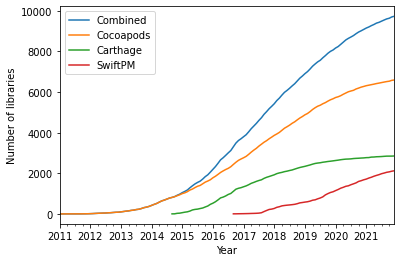

In [11]:
versions_firsts = versions.loc[versions.groupby(['name', 'type']).timestamp.idxmin()]

required_cocoapods = versions_firsts[(versions_firsts['type'] == 'cocoapods')  & (versions_firsts['year'] != '2022')].groupby(['month']).size().cumsum()
required_carthage = versions_firsts[(versions_firsts['type'] == 'carthage') & (versions_firsts['year'] != '2022')].groupby(['month']).size().cumsum()
required_swiftpm = versions_firsts[(versions_firsts['type'] == 'swiftpm') & (versions_firsts['year'] != '2022')].groupby(['month']).size().cumsum()

versions_all = versions.loc[versions.groupby(['name']).timestamp.idxmin()]
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size().cumsum()

results_firsts = pd.DataFrame({'Combined': required_data, 'Cocoapods': required_cocoapods, 'Carthage': required_carthage, 'SwiftPM': required_swiftpm})

results_firsts.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of libraries")
plt.tight_layout

plt.savefig('plot_number_of_libraries_cumulative_per_package_manager.pdf', bbox_inches = "tight")

Second we plot the cumulative number of library versions over time. 

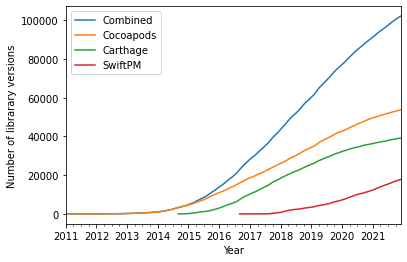

In [12]:
required_cocoapods = versions[(versions['type'] == 'cocoapods')  & (versions['year'] != '2022')].groupby(['month']).size().cumsum()
required_carthage = versions[(versions['type'] == 'carthage') & (versions['year'] != '2022')].groupby(['month']).size().cumsum()
required_swiftpm = versions[(versions['type'] == 'swiftpm') & (versions['year'] != '2022')].groupby(['month']).size().cumsum()

versions_all = versions[['name', 'month', 'year', 'timestamp']]
versions_all = versions_all.drop_duplicates()
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size().cumsum()

results_firsts = pd.DataFrame({'Combined': required_data, 'Cocoapods': required_cocoapods, 'Carthage': required_carthage, 'SwiftPM': required_swiftpm})

results_firsts.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of librarary versions")
plt.tight_layout

plt.savefig('plot_number_of_library_updates_cumulative_per_package_manager.pdf', bbox_inches = "tight")

Third we plot the number of library updates per month: 

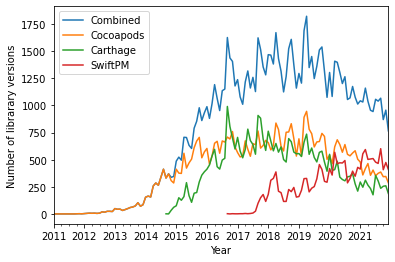

In [13]:
required_cocoapods = versions[(versions['type'] == 'cocoapods')  & (versions['year'] != '2022')].groupby(['month']).size()
required_carthage = versions[(versions['type'] == 'carthage') & (versions['year'] != '2022')].groupby(['month']).size()
required_swiftpm = versions[(versions['type'] == 'swiftpm') & (versions['year'] != '2022')].groupby(['month']).size()

versions_all = versions[['name', 'month', 'year', 'timestamp']]
versions_all = versions_all.drop_duplicates()
required_data = versions_all[ (versions_all['year'] != '2022')].groupby(['month']).size()

results_firsts = pd.DataFrame({'Combined': required_data, 'Cocoapods': required_cocoapods, 'Carthage': required_carthage, 'SwiftPM': required_swiftpm})

results_firsts.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of librarary versions")
plt.tight_layout

plt.savefig('plot_number_of_library_updates_per_month_per_package_manager.pdf',  bbox_inches = "tight")

Fourth we calculate snapshots of the library dependency network for each month. For this we query information on library versions and their dependencies: 

    match 
        (a:App)-[:IS]->(l:Library) 
    optional match 
        (a)-[r:DEPENDS_ON]->(dependency:Library) 
    optional  match 
        (dependent:App)-[s:DEPENDS_ON]->(l) 
    return 
        a.name as library_name, 
        a.tag as tag, 
        a.timestamp as timestamp, 
        count(DISTINCT dependency.name) as dependency_count, 
        count(DISTINCT dependent.name) as dependent_count, 
        r.type as type

In [14]:
dependencies = pd.read_csv('dependencies_with_type_new.csv')

In [15]:
dependencies['date'] = dependencies['timestamp'].apply(datetime.datetime.fromtimestamp)
dependencies['month'] = dependencies['date'].dt.to_period('M')
dependencies['year'] = dependencies['date'].dt.to_period('Y')

The following function finds, for each month, the most recent library version. 

In [16]:
months = pd.Series(versions['month'].unique()).sort_values().reset_index()[0]

def generate_df_with_up_to_month(original_df, period_values):
    return generate_df_with_up_to_month_variable(original_df, period_values, 'dependency_count')

def generate_df_with_up_to_month_variable(original_df, period_values, dep_name):
    df = pd.DataFrame()
    values = []
    month_values = []
    
    for i in range(1, len(period_values) - 1):
        unique_libraries = original_df[original_df['month'].between(months[1], months[i])].groupby(['library_name'])[['timestamp', dep_name]].max().reset_index()
        values.append(unique_libraries[dep_name].sum())
        month_values.append(months[i])
        
    df['month'] = month_values
    df['dependency_sum'] = values
    
    return df

In the follwing we plot the number of dependencies for the monthly snapshots. 

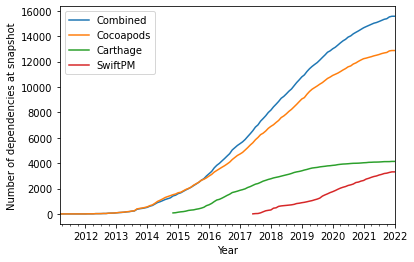

In [17]:
df_cocoapods = generate_df_with_up_to_month(dependencies[(dependencies['type'] == 'cocoapods') & (dependencies['year'] != '2022')], months)
df_carthage = generate_df_with_up_to_month(dependencies[(dependencies['type'] == 'carthage') & (dependencies['year'] != '2022')], months)
df_swiftpm = generate_df_with_up_to_month(dependencies[(dependencies['type'] == 'swiftpm') & (dependencies['year'] != '2022')], months)


dependencies_all = dependencies.loc[dependencies.groupby(['library_name']).timestamp.idxmin()]
df_all = generate_df_with_up_to_month(dependencies_all[(dependencies_all['year'] != '2022')], months)

co_data = df_cocoapods.groupby('month')['dependency_sum'].max()
ca_data = df_carthage.groupby('month')['dependency_sum'].max()
sw_data = df_swiftpm.groupby('month')['dependency_sum'].max()
all_data = df_all.groupby(['month'])['dependency_sum'].max()

ca_data[ ca_data==0 ] = np.nan
sw_data[ sw_data==0 ] = np.nan
df_all[ df_all==0 ] = np.nan

snapshot_results = pd.DataFrame({'Combined': all_data, 'Cocoapods': co_data, 'Carthage': ca_data, 'SwiftPM': sw_data})

snapshot_results.plot()
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Number of dependencies at snapshot")

plt.tight_layout

plt.savefig('plot_number_of_library_dependencies_snapshot_per_package_manager.pdf', bbox_inches = "tight")

Fifth we plot the mean number of direct depndencies for new library verisons released each month for each package manager. 

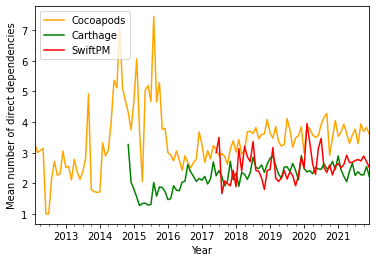

In [18]:
co_data_dep = dependencies[(dependencies['type'] == 'cocoapods') & (dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean()
ca_data_dep = dependencies[(dependencies['type'] == 'carthage') & (dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean()
sw_data_dep = dependencies[(dependencies['type'] == 'swiftpm') & (dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean()

results1 = pd.DataFrame({'Cocoapods': co_data_dep, 'Carthage': ca_data_dep, 'SwiftPM': sw_data_dep})

results1.plot(color = ['orange', 'green', 'red'])
plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Mean number of direct dependencies")
plt.tight_layout

plt.savefig('plot_mean_number_of_depenencies_per_month_per_package_manager.pdf', bbox_inches = "tight")

As an additional plot the mean number of direct dependencies for all library versions without distinguishing between package managers: 

<AxesSubplot:xlabel='month'>

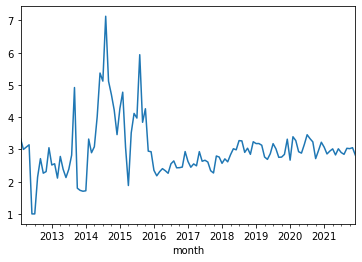

In [19]:
dependencies[(dependencies['year'] != '2022')].groupby(['month'])['dependency_count'].mean().plot()

Another additional plot adds a trend line to the number of dependencies between 2016 and 2022.

In [20]:
def get_line_for_depenencies(original, date1, date2, key):
    data = original[(original['month'].between(date1, date2)) & (original[key] > 0)].groupby(['month'])[key].mean()
    data_df = data.to_frame().reset_index()

    data_df['month_int'] = data_df['month'].apply(lambda x: (x.year - 2012) * 12 + x.month)

    X = np.array(data_df['month_int'])[::, None]
    y = np.array(data_df[key])[::, None]

    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0] 

    fittedline = slope*X + intercept
    fittedline = fittedline.flatten()
    return fittedline, data_df

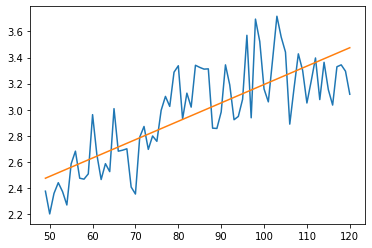

In [21]:
fittedline, data_df = get_line_for_depenencies(dep_no_type, '2016.01.01', '2021.12.31', 'dependency_count')

plt.plot(data_df['month_int'], data_df['dependency_count'])
plt.plot(data_df['month_int'], fittedline)

Another additional plot shows the trendlines for each package manager. 

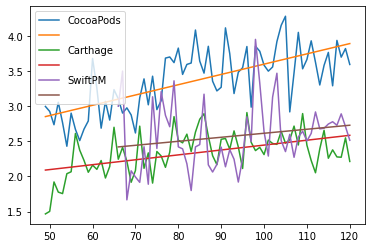

In [22]:
cocoapdos_data = dependencies[(dependencies['type'] == 'cocoapods')]
carthage_data = dependencies[(dependencies['type'] == 'carthage')]
swiftpm_data = dependencies[(dependencies['type'] == 'swiftpm')]

fittedline_co, data_df_co = get_line_for_depenencies(cocoapdos_data, '2016.01.01', '2021.12.31', 'dependency_count')
fittedline_ca, data_df_ca = get_line_for_depenencies(carthage_data, '2016.01.01', '2021.12.31', 'dependency_count')
fittedline_s, data_df_s = get_line_for_depenencies(swiftpm_data, '2016.01.01', '2021.12.31', 'dependency_count')


plt.plot(data_df_co['month_int'], data_df_co['dependency_count'])
plt.plot(data_df_co['month_int'], fittedline_co)

plt.plot(data_df_ca['month_int'], data_df_ca['dependency_count'])
plt.plot(data_df_ca['month_int'], fittedline_ca)

plt.plot(data_df_s['month_int'], data_df_s['dependency_count'])
plt.plot(data_df_s['month_int'], fittedline_s)

plt.legend(['CocoaPods', '', 'Carthage', '', 'SwiftPM', ''], loc='upper left')

Another additional plot shows the mean number of dependents for library versions added each month. 

Text(0, 0.5, 'Mean number of dependents')

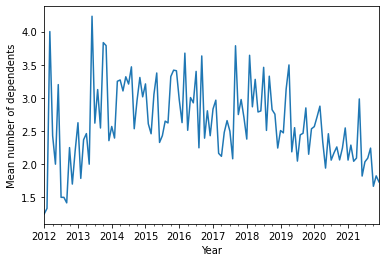

In [23]:
dep_no_type[(dep_no_type['month'].between('2012.01.01', '2021.12.31')) & (dep_no_type['dependent_count'] > 0)].groupby(['month'])['dependent_count'].mean().plot()

plt.xlabel("Year")
plt.ylabel("Mean number of dependents")

Sixth we plot the total number of dependencies for each month. For this we first read in csv file with information on all analysed library versions with dependencies that includes the number of total dependencies. Total dependencies = direct + indirect dependencies. 

Query used: 

    match 
        (a:App)-[:IS]->(l:Library)-[:LIBRARY_DEPENDS_ON*1..10]->(vl:Library)
    return 
        a.name as library_name, 
        a.tag as tag, 
        a.timestamp as timestamp,
        count(distinct vl) as total_dependencies_count

In [24]:
total_dependencies_data = pd.read_csv('total_dependencies_count_new2.csv')

In [25]:
total_dependencies_data['date'] = total_dependencies_data['timestamp'].apply(datetime.datetime.fromtimestamp)
total_dependencies_data['month'] = total_dependencies_data['date'].dt.to_period('M')
total_dependencies_data['year'] = total_dependencies_data['date'].dt.to_period('Y')

total_dependencies_data = total_dependencies_data[total_dependencies_data['year'] != '2022']

In [26]:
total_dependencies_data['date'] = total_dependencies_data['timestamp'].apply(datetime.datetime.fromtimestamp)
total_dependencies_data['month'] = total_dependencies_data['date'].dt.to_period('M')
total_dependencies_data['year'] = total_dependencies_data['date'].dt.to_period('Y')

total_dependencies_data = total_dependencies_data[total_dependencies_data['year'] != '2022']

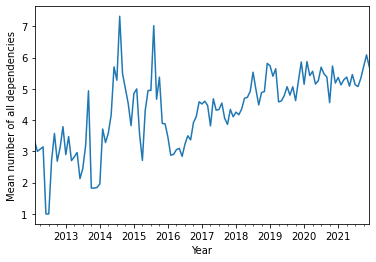

In [27]:
total_dependencies_data[(total_dependencies_data['month'].between('2012.01.01', '2021.12.31')) & (total_dependencies_data['total_dependencies_count'] > 0)].groupby(['month'])['total_dependencies_count'].mean().plot()

plt.xlabel("Year")
plt.ylabel("Mean number of all dependencies")

plt.savefig('plot_mean_number_of_all_dependencies_per_month.pdf', bbox_inches = "tight")

Additional plot showing the trendline for total number of dependnecies. 

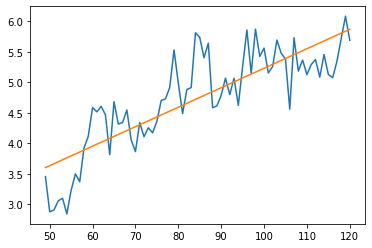

In [28]:
fittedline, data_df = get_line_for_depenencies(total_dependencies_data, '2016.01.01', '2021.12.31', 'total_dependencies_count')

plt.plot(data_df['month_int'], data_df['total_dependencies_count'])
plt.plot(data_df['month_int'], fittedline)

# RQ3: Impact of Vulnerabilities on Libraries in Co- coaPods, Carthage, and Swift PM

To analyse how vulnerabilities spread thorugh the library dependency network we look at two different aspects:

1. How close or far vulnerabilities appear on the dependency chain
2. How long maximal dependency chains are for vulnerable libraries

Frist we query dependency chains that end in vulnerable library versions. 

     match (l:Library)-[:LIBRARY_DEPENDS_ON*0..]->(vl:Library)-[:HAS_VULNERABILITY]->(v:Vulnerability)
     match path = shortestPath((vl)<-[:LIBRARY_DEPENDS_ON*0..]-(l))
     with l, length(path) as lengths
     with l, min(lengths) as shortest
     with shortest, collect(distinct l.name) as names
     unwind names as name
     return name, shortest

In [29]:
vulnerable_libraries = pd.read_csv('libraries_with_shortest_dependency_to_vulnerability.csv')

We then drop duplicate library names: 

In [30]:
vulnerable_libraries_no_dups = vulnerable_libraries.drop_duplicates('name')

In [31]:
vulnerable_libraries_no_dups.groupby('shortest').count()

,name
shortest,
0,41
1,202
2,83
3,126
4,2
5,1
6,1


We then plot the number of libraries for each dependency level cumulatively:

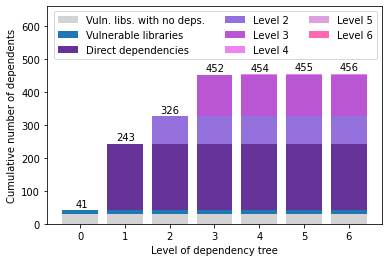

In [32]:
level0 = np.array([12,12,12,12,12,12,12])
level0b = np.array([29,29,29,29,29,29,29])
level1 = np.array([0,202, 202, 202, 202, 202, 202])
level2 = np.array([0,0,83,83,83,83,83])
level3 = np.array([0,0,0,126,126,126,126])
level4 = np.array([0,0,0,0,2,2,2])
level5 = np.array([0,0,0,0,0,1,1])
level6 = np.array([0,0,0,0,0,0,1])

values = [41,202,83,126,2,1, 1]
value_series = pd.Series(np.array(values))

fig, ax = plt.subplots()
labels = ['0', '1', '2', '3', '4', '5', '6']

ax.bar(labels, level0b, label='Vuln. libs. with no deps.', color='lightgray')#, edgecolor='tab:blue')
ax.bar(labels, level0, label='Vulnerable libraries', bottom=level0b, color='tab:blue')#, edgecolor='tab:blue')
ax.bar(labels, level1, label= 'Direct dependencies', bottom=level0b + level0, color='rebeccapurple')#, edgecolor='rebeccapurple')
ax.bar(labels, level2,label= 'Level 2', bottom=level0 + level0b + level1, color='mediumpurple')#, edgecolor='mediumpurple')
ax.bar(labels, level3,label= 'Level 3', bottom=level0 + level0b + level1 + level2, color='mediumorchid')#, edgecolor='mediumorchid')
ax.bar(labels, level4,label= 'Level 4', bottom=level0 + level0b + level1 + level2 + level3, color='violet')#, edgecolor='violet')
ax.bar(labels, level5,label= 'Level 5', bottom=level0 + level0b + level1 + level2 + level3 + level4, color='plum')#, edgecolor='hotpink')
ax.bar(labels, level6,label= 'Level 6', bottom=level0 + level0b + level1 + level2 + level3 + level4 + level5, color='hotpink')#, edgecolor='lavenderblush')

for i, value in enumerate(value_series.cumsum()):
    padding = len(str(value))
    
    ax.text(i + 0.1 - 0.1*padding, value + 10, str(value))
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, 1.02*ymax)
ax.set_ylim(0, 660)


plt.xlabel("Level of dependency tree")
plt.ylabel("Cumulative number of dependents")
plt.tight_layout

ax.legend(ncol=3)

plt.savefig('plot_vulnerability_bar_cumulative.pdf', bbox_inches = "tight")

We then query for each vulnerable library version lengths of dependency paths to each of its dependents.  

     match path = (l:Library)-[:LIBRARY_DEPENDS_ON*0..]->(vl:Library)-[:HAS_VULNERABILITY]->(v:Vulnerability)
     with vl, length(path) as length
     return vl.name, vl.version, length

match path = (l:Library)-[:LIBRARY_DEPENDS_ON*0..]->(vl:Library)-[:HAS_VULNERABILITY]->(v:Vulnerability)
with vl, length(path) - 1 as length, l
return vl.name as name, vl.version as version, length, l.name as dependent_name, l.version as dependent_version

In [33]:
vulnerability_path_length = pd.read_csv('vulnerability_path_length.csv')

Drop duplicates for each library name and dependency path length. 

In [34]:
vulnerability_path_length_no_dups = vulnerability_path_length.drop_duplicates(subset=['name', 'length'])

In [35]:
vulnerability_path_length_no_dups.groupby('length')['name'].count()

length
0     41
1     12
2      7
3      7
4      4
5      2
6      2
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
Name: name, dtype: int64

And finally plot the results. 

<AxesSubplot:xlabel='length'>

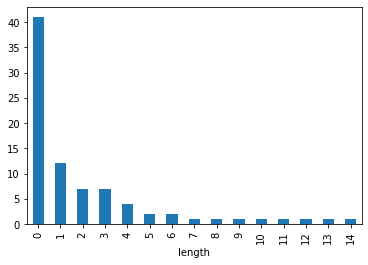

In [36]:
vulnerability_path_length_no_dups.groupby('length')['name'].count().plot(kind='bar')

In the following we omit some duplicate values and make the above plot nicer: 

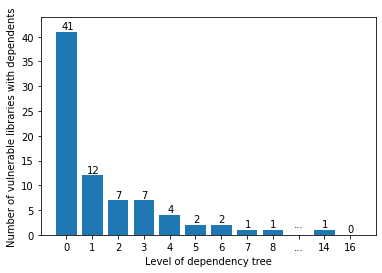

In [37]:
values = [41,12,7,7,4,2, 2, 1,1, 0,1 , 0]

fig, ax = plt.subplots()
ax.bar(['0','1', '2', '3', '4', '5', '6', '7', '8','...', '14', '16'], values)

for i, value in enumerate(values):
    padding = len(str(value))
    
    value_s = str(value)
    if i == 9:
        value = 1
        value_s = '...'
        padding = len(str('..'))
    
    ax.text(i + 0.0 - 0.1*padding, value + 0.5, value_s)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, 1.02*ymax)

plt.xlabel("Level of dependency tree")
plt.ylabel("Number of vulnerable libraries with dependents")
plt.tight_layout

plt.savefig('plot_vulnerability_bar_dependents.pdf', bbox_inches = "tight")

As an addtional plot below is the same plot for versions: 

<AxesSubplot:xlabel='length'>

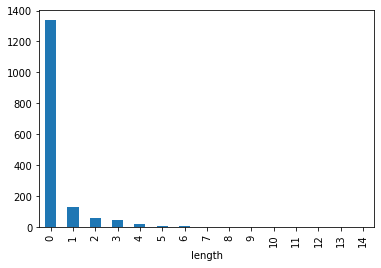

In [38]:
vulnerability_path_length.drop_duplicates(subset=['name', 'length', 'version']).groupby('length')['version'].count().plot(kind='bar')

Below are some additional plots that include the number of all chains and the number of unique dependent library versions. 

<AxesSubplot:xlabel='length'>

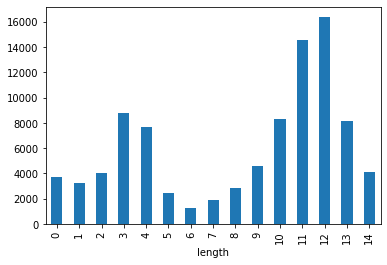

In [39]:
vulnerability_path_length.groupby('length')['version'].count().plot(kind='bar')

<AxesSubplot:xlabel='length'>

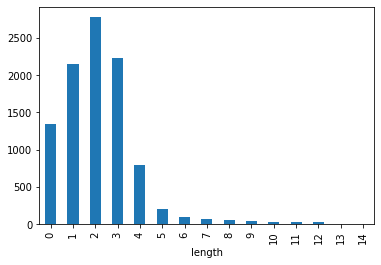

In [40]:
vulnerability_path_length.drop_duplicates(subset=['name', 'length', 'version', 'dependent_name', 'dependent_version']).groupby('length')['version'].count().plot(kind='bar')

<AxesSubplot:xlabel='length'>

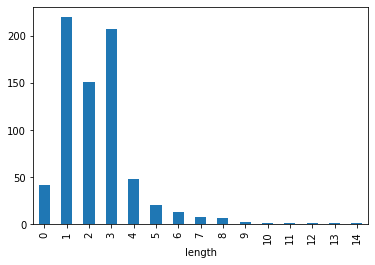

In [41]:
vulnerability_path_length.sort_values('length', ascending=True).drop_duplicates(subset=['name', 'length','dependent_name']).groupby('length')['version'].count().plot(kind='bar')


This first plot in RQ3 can also be derived from the vulnerabilty_path_length data.

<AxesSubplot:xlabel='length'>

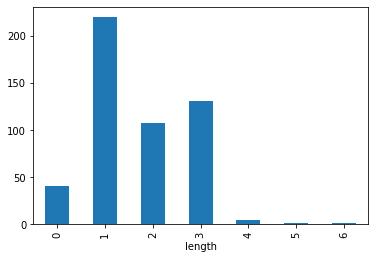

In [42]:
vulnerability_path_length.sort_values('length', ascending=True).drop_duplicates(subset=['name', 'dependent_name']).groupby('length')['version'].count().plot(kind='bar')
